# LDA example
Para este ejemplo, tomé textos de Customer Support de Nuvemshop, correspondientes a tres topics que ya sabemos que existen porque están etiquetados manualmente. Elegí los topics de “domains”, “billing” y “shipping”. 

In [1]:
#Imports
import pandas as pd
pd.options.display.max_columns = None
import numpy as np

import pyLDAvis
import pyLDAvis.sklearn

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA

#For c-vectorizer
def do_nothing(x):
    return x

### Primer paso: limpieza del texto y creación del vocabulario
El primer paso fue ordenar los textos y limpiarlos. Dejamos solamente las palabras importantes (sustantivos, adjetivos y verbos) y eliminamos todas las demás. Las pasamos a minúscula y sacamos todos los acentos o diacríticos. Luego, a partir de esos textos limpios, creamos un diccionario con las palabras que aparecen en al menos 15 documentos (las muy particulares) y que aparecen en menos del 95% de los documentos (es decir las muy repetidas entre todos los textos). Con este diccionario, creamos una forma de describir los textos que se llama matriz esparsa, que no es otra cosa que una tabla muy muy grande. Cada columna es una palabra de nuestro vocabulario y cada fila es un documento. Cada celda pone como valor cuántas veces aparece esa palabra en el texto. El nombre de esparsa viene por el hecho de que va a haber muchos 0 y los valores que no son 0 están “esparcidos” por toda la tabla. 


In [2]:
#This dataframe was preprocessed and cleaned with Stanza (https://stanfordnlp.github.io/stanza/)
#It has a topic (labelled by Customer Support Agents) and a lemmatized text
df = pd.read_pickle('article.pik')

In [3]:
df.columns

Index(['Topic', 'Palabras'], dtype='object')

In [4]:
#Delete:
#Words in less than 15 documents (min document frequency int)
#Words in more than 95% documents (max document frequency float is %)
#Use bigrams

cv = CountVectorizer(lowercase=False,tokenizer=do_nothing, max_df = 0.95, min_df=15, ngram_range = (1,2)) 
cv_matrix = cv.fit_transform(df.Palabras.dropna())

In [5]:
cv_matrix

<3650x732 sparse matrix of type '<class 'numpy.int64'>'
	with 45481 stored elements in Compressed Sparse Row format>

In [6]:
df.Topic.value_counts(normalize = True)

Domain      0.364658
Billing     0.352603
Shipping    0.282740
Name: Topic, dtype: float64

### Segundo paso: encontramos la función de Dirichlet
Esto lo hace un algoritmo que ya está escrito. Pero básicamente lo que hacemos es pasarle todos los datos de nuestra matriz esparsa y la cantidad de topics que queremos encontrar. Este algoritmo nos devuelve las funciones de probabilidad de las palabras de cada topic y además, nos dice para cada documento qué cantidad de cada tema tiene. Veamos qué palabras encontró como más probables para cada uno de los temas. Hay que recordar que nunca le dijimos qué temas le íbamos a pasar, es decir, solamente los infirió a partir de los textos que le pasamos y la cantidad de grupos en los que le pedimos que dividiera nuestros textos. Entonces nosotros le pedimos 3 grupos y le pasamos todos los textos limpios.


In [7]:
lda = LatentDirichletAllocation(n_components = 3, max_iter = 50, learning_decay = 0.052, n_jobs = 3, random_state = 42)
trans_matrix = lda.fit_transform(cv_matrix)
trans_matrix

array([[0.02843129, 0.37315538, 0.59841333],
       [0.02711567, 0.11349119, 0.85939314],
       [0.01087436, 0.18821457, 0.80091106],
       ...,
       [0.0066178 , 0.32215288, 0.67122932],
       [0.95451689, 0.02298786, 0.02249524],
       [0.96015123, 0.02023456, 0.01961422]])

In [8]:
#Topic keywords y peso
df_topic_keywords = pd.DataFrame(lda.components_)
df_topic_keywords.columns = cv.get_feature_names()
df_topic_keywords = df_topic_keywords.T
df_topic_keywords.columns = ['tema_1', 'tema_2', 'tema_3']

Al explorar las palabas más importantes en cada uno de los temas vemos lo siguiente:

In [9]:
#5 mas importantes tema 1
print(df_topic_keywords.sort_values('tema_1', ascending = False).head(5).index)
#5 mas importantes tema 2
print(df_topic_keywords.sort_values('tema_2', ascending = False).head(5).index)
#5 mas importantes tema 3
print(df_topic_keywords.sort_values('tema_3', ascending = False).head(5).index)


Index(['frete', 'cliente', 'opcao', 'envio', 'aparecer'], dtype='object')
Index(['dominio', 'com.br', 'tentar', 'aparecer', 'vincular'], dtype='object')
Index(['pagamento', 'pagar', 'plano', 'email', 'teste'], dtype='object')


Recordemos que estamos trabajando con textos de shipping, dominios y billing. Mirando estas 5 palabras, ya podemos inferir a qué grupo pertenece cada listado.

### Tercer paso: clasificar los textos y visualizar
En este último paso juntamos las tags con lo que encontró nuestro algoritmo sin supervisión. Para el siguiente gráfico agrupamos todos los textos por tag y calculamos la mediana de cada tema identificado por el LDA.  


In [10]:
user_df = pd.DataFrame(trans_matrix, columns= ['lda_1','lda_2','lda_3'] )
df_user = df.join(user_df)

In [11]:
for_heat = df_user.groupby(['Topic']).agg({
    'lda_1' : 'median',
    'lda_2' : 'median', 
    'lda_3' : 'median', 
})

Text(68.09375, 0.5, 'Mediana de grupos de LDA reconocidos')

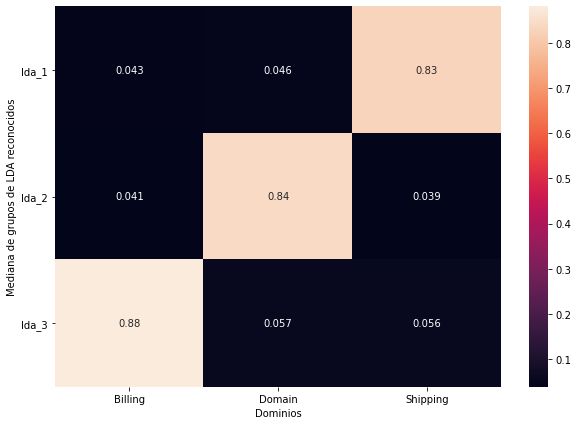

In [12]:
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(for_heat.T, annot=True)
plt.yticks(rotation=0)
ax.set_xlabel('Dominios', fontsize=10)
ax.set_ylabel('Mediana de grupos de LDA reconocidos', fontsize=10)

In this case we used an external evaluation of the LDA results, i.e. the correspondence with Topics labelled by gurús. 

If we don't have supervised data, we should use other ways to assess the quality of the model. See:
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
https://www.cs.cmu.edu/~rsalakhu/papers/etm.pdf


Acá lo que vemos es, para los textos de Shipping, la mediana del topic 1 encontrado por LDA es de 0.83 (el rango va de 0 a 1), mientras que para los otros lda_2 y lda_3 es muy baja. Lo mismo para Domain y el topic 2 y para Billing y el topic 3. Hay que recordar que NO usamos las etiquetas para agrupar los textos, solamente usamos sus palabras. Si nos fijamos en las keywords, vemos que esas keywords...

- Tema 1: 'frete', 'cliente', 'opcao', 'envio', 'aparecer'
- Tema 2: 'dominio', 'com.br', 'tentar', 'aparecer', 'vincular'
- Tema 3: 'pagamento', 'pagar', 'plano', 'email', 'teste'

¡Tienen sentido! 

Entonces podríamos decir que cada uno de los temas se relacionan muy estrechamente con los temas que se habían taggeado. 


### Finalmente, veamos el famoso “triángulo”  

Para este gráfico tuvimos que reducir la dimensionalidad con otra técnica llamada PCA (teníamos 3 temas y la pasamos a 2 para poder visualizarla en un plano de dos dimensiones). Lo que vemos es que cada vértice (que representa un tema) tiene agrupado bastantes puntitos de un solo color. Además, vemos que no hay muchos puntos en el medio del triángulo. También vemos que hay puntos que están a mitad de camino entre dos dominios, eso significa que tienen un poco de cada tema. 


In [13]:
pca = PCA(n_components=2)
pcas = pca.fit_transform(trans_matrix)

In [14]:
df_user['pca_1'] = [pc[0] for pc in pcas]
df_user['pca_2'] = [pc[1] for pc in pcas]

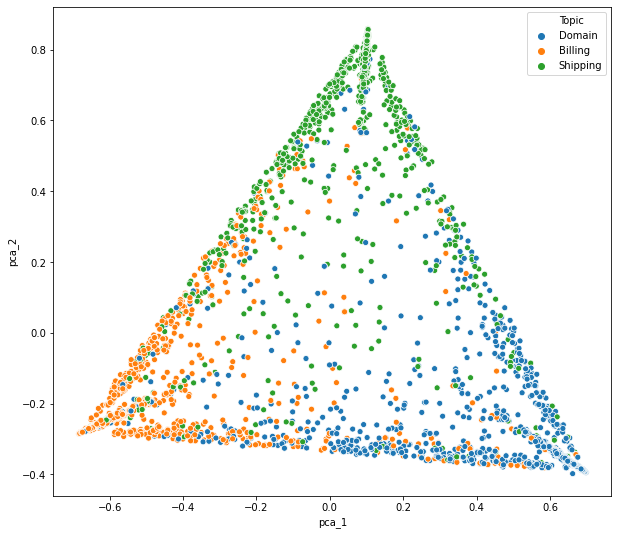

In [15]:
f, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(x='pca_1', y='pca_2', hue = 'Topic', data = df_user)

In [16]:
#With this we generated an interactive panel to explore the results of the modeling.
panel = pyLDAvis.sklearn.prepare(lda, cv_matrix,  cv, mds='tsne', sort_topics=False, n_jobs = 1)
pyLDAvis.save_html(panel, 'lda_test_case.html')

### A modo de cierre
La técnica de LDA nos permite explorar textos y buscar temas “latentes”. A veces funciona muy bien, pero otras veces puede no hacerlo, va a depender de nuestra colección de textos. Como técnica exploratoria es sumamente útil, nos permite entender cómo se relacionan los diferentes temas entre sí y descubrir temas que no sabíamos que existen. Además nos ayuda a obtener keywords de cada tema y sus pesos, lo que a la vez, nos permite identificar un tema. También nos permite ver si una colección de textos tiene diferentes temas. Además, abre la pregunta adicional ¿Se pueden reconocer subtemas dentro de cada tema? ¿Cuántos y cuáles? 
